In [51]:
%matplotlib inline

In [21]:
import sys
sys.path.append('..')
from ai4mat.data.data import (
    read_structures_descriptions,
    read_defects_descriptions,
    Columns
)

In [54]:
import numpy as np
import matplotlib.pyplot as plt

In [45]:
from itertools import chain
from collections import Counter
from operator import itemgetter

In [13]:
data_path = "../datasets/POSCARs/MoS2"
structures = read_structures_descriptions(data_path)
defects = read_defects_descriptions(data_path)
COLUMNS = Columns()

In [28]:
defect_descriptions = defects.loc[structures.loc[:, COLUMNS["structure"]["descriptor_id"]], "defects"]

In [32]:
class hashabledict(dict):
    def __hash__(self):
        return hash(frozenset(self.items()))

In [37]:
all_defects = frozenset(map(hashabledict, chain.from_iterable(defect_descriptions)))

In [39]:
all_defects

frozenset({{'type': 'substitution', 'from': 'Mo', 'to': 'W'},
           {'type': 'substitution', 'from': 'S', 'to': 'Se'},
           {'type': 'vacancy', 'element': 'Mo'},
           {'type': 'vacancy', 'element': 'S'}})

In [40]:
per_structure_counts = [Counter(map(hashabledict, this_structure_defect)) for this_structure_defect in defect_descriptions]

In [55]:
count_distributions = {
    defect_type: np.fromiter(
        map(itemgetter(defect_type), per_structure_counts),
        dtype=int, count=len(per_structure_counts)) \
    for defect_type in all_defects
}

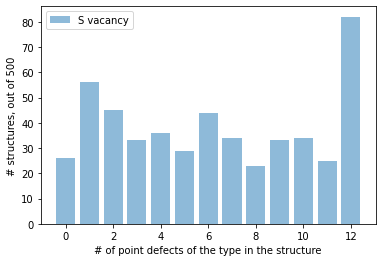

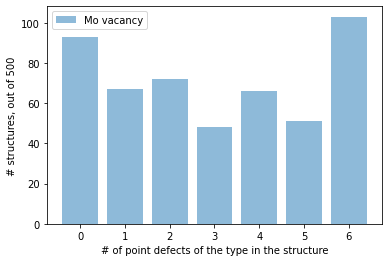

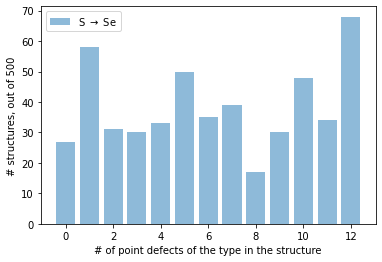

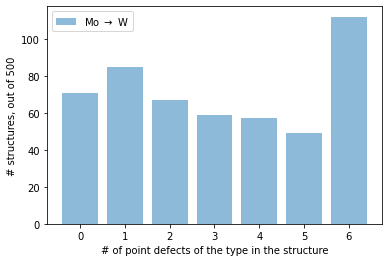

In [70]:
for defect_type, counts in count_distributions.items():
    fig, ax = plt.subplots()
    values, counts_of_counts = np.unique(counts, return_counts=True)
    if defect_type['type'] == 'vacancy':
        label = f'{defect_type["element"]} vacancy'
    else:
        label = f'{defect_type["from"]} $\\rightarrow$ {defect_type["to"]}'
    ax.bar(values, counts_of_counts, label=label, alpha=0.5)
    ax.legend()
    ax.set_ylabel(f"# structures, out of {len(per_structure_counts)}")
    ax.set_xlabel("# of point defects of the type in the structure")
    fig.savefig(f"defect_density_plots/{str(defect_type)}.pdf", bbox_inches='tight')